<h2>This dataset presents a list of the 100 most streamed songs on Spotify of all time</h2>
(This dataset dates from March 8th 2023. Updates might've happened by the time you read this)  


Dataset source: https://www.kaggle.com/datasets/amaanansari09/most-streamed-songs-all-time




<h3>1. Features description:</h3>

- <b>duration:</b> Duration of the song (minutes).


- <b>energy:</b> A perceptual measure of intensity and activity.


- <b>key:</b> The harmony key, being 0 = C, 1 = C#, ... , 11 = B


- <b>loudness:</b> The overall loudness of a track in decibels (dB).


- <b>mode:</b> 0 = Major Key; 1 = Minor Key;


- <b>speechiness:</b> ?


- <b>acousticness:</b> ?


- <b>instrumentalness:</b> ?


- <b>liveness:</b> ?


- <b>valence:</b> ?


- <b>tempo:</b> Rhythm of the song (beats/min or bpm)


- <b>danceability:</b> ?






<h3>2. Objectives and Key Insights</h3>

<h4> Answers to be found:</h4>

1. How many artists made it to the top 100 most streamed songs of all time on Spotify?

2. Who are the artists with more songs in the list

3. Who are the artists with more streams in the list

4. Is there a pattern in terms of "key" and "mode" for these top songs?

5. Do these songs gravitate around an "optimal duration"?

6. Is there a correlation between "streams" and "tempo"? 

7. Do these songs gravitate around an "tempo"?

8. What are the artists with more streams per day?

9. What artist have the oldest song in the list, and which song is it?

10. How much revenue all 100 songs have made together?



<h4> Insights that cannot be leveraged with this dataset (and I am particularly interested in!!):</h4>

1. What are the chord progressions of each song? Is there a pattern among these top streamed ones?

2. What is the primary language the song is sung in? And how many words are there?

3. What are the song structures used by each song? (e.g. Intro, Verse, Bridge, Pre Chorus, Chorus, Otro, etc.)

4. What is the total number of streams these artists have now and before launching each of these songs?

5. How much revenue each song has made?


<h3>3. Loading data and libraries</h3>

<i>Here we load all the libs necessary to transform the data and perform analyses</i>

In [176]:
# Import everything you need
import pandas as pd
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import date
from dateutil.parser import parse

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 10000)

In [177]:
# Set-up the input files with da data to be analyzed
features_file_path = f"../datasets/Spotify Songs/Features.csv"

streams_file_path = f"../datasets/Spotify Songs/Streams.csv"

<h3>4. Data Transformations</h3>

<i>This is the section we perform all adjustments in our data to make it ready for usage/analyses</i>

In [178]:
# Do all transformations needed to your data and enable analysis
df_features = pd.read_csv(features_file_path)
df_streams = pd.read_csv(streams_file_path)

df_merge = pd.merge(left=df_streams, left_on="Song", right=df_features, right_on="name")

df_merge = df_merge[["Song", "Artist", "Streams (Billions)", "Release Date", "duration", "energy", "key", "mode", "loudness", "tempo"]]

todays_date = date(2023, 3, 8)
df_merge.insert(4, "Today", todays_date)
df_merge['Release Date'] = df_merge['Release Date'].astype('string')
df_merge['Release Date'] = df_merge['Release Date'].apply(lambda x: parse(x).date())

df_merge['Aging in Days'] = df_merge['Today'] - df_merge['Release Date']
df_merge['Aging in Days'] = df_merge['Aging in Days'].dt.total_seconds() / (60*60*24)

df_merge



,Song,Artist,Streams (Billions),Release Date,Today,duration,energy,key,mode,loudness,tempo,Aging in Days
0,Blinding Lights,The Weeknd,3.449,2019-11-29,2023-03-08,3.33,0.730,1,1,-5.934,171.005,1195.0
1,Shape of You,Ed Sheeran,3.398,2017-01-06,2023-03-08,3.90,0.652,1,0,-3.183,95.977,2252.0
2,Dance Monkey,Tones And I,2.770,2019-05-10,2023-03-08,3.49,0.588,6,0,-6.400,98.027,1398.0
3,Someone You Loved,Lewis Capaldi,2.680,2018-11-08,2023-03-08,3.04,0.405,1,1,-5.679,109.891,1581.0
4,Rockstar,Post Malone featuring 21 Savage,2.620,2017-09-15,2023-03-08,3.64,0.520,5,0,-6.136,159.801,2000.0
5,Sunflower,Post Malone and Swae Lee,2.575,2018-10-18,2023-03-08,2.63,0.479,2,1,-5.574,89.911,1602.0
6,One Dance,Drake featuring Wizkid and Kyla,2.556,2016-04-05,2023-03-08,2.90,0.625,1,1,-5.609,103.967,2528.0
7,Closer,The Chainsmokers featuring Halsey,2.481,2016-07-29,2023-03-08,4.08,0.524,8,1,-5.599,95.010,2413.0
8,Stay,The Kid Laroi and Justin Bieber,2.432,2021-07-09,2023-03-08,4.01,0.310,9,0,-10.164,111.893,607.0
9,Believer,Imagine Dragons,2.410,2017-02-01,2023-03-08,3.41,0.780,10,0,-4.374,124.949,2226.0


<h5>Define all methods to structure data</h5>
<i>In this section, we define custom methods that will help us build the final form/structure of our datasets. Note that we're still in the "Data Transformations" stage.</i>


In [179]:
# Function to split "featuring" and "and" artists and concat
def splitArtist(dataframe, separator):
    aux = dataframe[dataframe['Artist'].str.contains(r'\b\s{0}\s\b'.format(separator), case=True)]
    aux = aux['Artist'].str.split(pat=r'\s{0}\s'.format(separator), n=1, expand=True)
    aux = pd.concat([aux[0], aux[1]], axis=0)
    return aux

# Generate all artists list
def findAllArtists(artist_objs_list, separator_word_list, sep):
    aux = pd.concat(artist_objs_list, axis=0)
    
    # This could be done in a single line, but this way has better readability
    regex_aux = r'\b\s{0}\s\b'
    sep_aux = sep.join(separator_word_list)
    filter_aux = aux.str.contains(regex_aux.format(sep_aux))
    aux = aux[~filter_aux]
    # Alternative:
    # aux = aux[~aux.str.contains(r'\b\s({0})\s\b'.format(sep.join(separator_word_list)))]
    
    aux = aux.dropna()
    aux = aux.drop_duplicates()
    return aux

# Count songs per artist
def countSongs(artistName, dataframeColumn):
    count = (dataframeColumn.str.contains(artistName)).sum()
    return count

# Sum streams per artist
def sumStreams(dataframe, artistName):
    aux = dataframe.loc[dataframe['Artist'].str.contains(artistName)]
    totalStreams = np.round(aux['Streams (Billions)'].sum(), 2)
    return totalStreams

# Find oldest song's name and aging
def findAging(dataframe, artistName):
    aux = dataframe.loc[dataframe['Artist'].str.contains(artistName)]
    aux = aux.sort_values(by='Aging in Days', ascending=False)
    oldestSong = aux['Song'].values[0]
    oldestSongAging = aux['Aging in Days'].values[0]
    return oldestSong, oldestSongAging

# Count streams per day
def streamsPerDay(dataframe):
    for index, row in dataframe.iterrows():
        dataframe.loc[index, 'Streams per day (Millions)'] = np.round(((10**3) * row[2]/row[5]), 2)
    return dataframe

# Compute estimated earnings, if 4000 USD per million views
def computeEarnings(dataframe):
    for index, row in dataframe.iterrows():
        dataframe.loc[index, "Estimated Earnings (Millions USD)"] = np.round((4000 * row[3]) * row[5]/(10**6), 2)
    return dataframe

def songEarnings(dataframe):
    for index, row in dataframe.iterrows():
        dataframe.loc[index, 'Estimated Earnings (Million USD)'] = np.round((4000 * (10**-3) * row[1]), 2)
    return dataframe

<i>And in this section, we apply all the methods we have just created.</i>

In [180]:
feat_df = splitArtist(df_merge, 'featuring')
and_df = splitArtist(df_merge, 'and')

artist_objs_list = [feat_df, and_df, df_merge['Artist']]
separator_word_list = ['featuring', 'and']
separator = '|'
all_artists = findAllArtists(artist_objs_list=artist_objs_list,         separator_word_list=separator_word_list, sep=separator)

df_uniq_art = pd.DataFrame(all_artists).rename(columns={0:'Artist'}).sort_values(by='Artist').reset_index(drop=True)
df_uniq_art['Songs'] = None
df_uniq_art['Streams (Billions)'] = None
df_uniq_art['Streams per day (Millions)'] = None
df_uniq_art['Oldest song'] = None
df_uniq_art['Oldest song aging'] = None
df_uniq_art['Estimated Earnings (Millions USD)'] = None

for index, row in df_uniq_art.iterrows():
    row[1] = countSongs(artistName=row[0], dataframeColumn=df_merge['Artist'])
    
for index, row in df_uniq_art.iterrows():
    row[2] = sumStreams(dataframe=df_merge, artistName=row[0])
    
for index, row in df_uniq_art.iterrows():
    df_uniq_art.loc[index, 'Oldest song'], df_uniq_art.loc[index, 'Oldest song aging'] = findAging(dataframe=df_merge, artistName=row[0])

df_uniq_art = streamsPerDay(df_uniq_art)

df_uniq_art = computeEarnings(df_uniq_art)

df_merge['Estimated Earnings (Million USD)'] = None
df_songs = df_merge[['Song', 'Streams (Billions)', 'Aging in Days', 'Estimated Earnings (Million USD)', 'key', 'mode', 'duration', 'tempo']]
df_songs_final = songEarnings(df_songs)

df_songs_final['tempo'] = np.round(df_songs_final['tempo'], 0) 

df_songs_final

/var/folders/tx/qf9y3mqn2w55cr5yxxdm0f340000gn/T/ipykernel_47107/1277912726.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Song,Streams (Billions),Aging in Days,Estimated Earnings (Million USD),key,mode,duration,tempo
0,Blinding Lights,3.449,1195.0,13.8,1,1,3.33,171.0
1,Shape of You,3.398,2252.0,13.59,1,0,3.90,96.0
2,Dance Monkey,2.770,1398.0,11.08,6,0,3.49,98.0
3,Someone You Loved,2.680,1581.0,10.72,1,1,3.04,110.0
4,Rockstar,2.620,2000.0,10.48,5,0,3.64,160.0
5,Sunflower,2.575,1602.0,10.3,2,1,2.63,90.0
6,One Dance,2.556,2528.0,10.22,1,1,2.90,104.0
7,Closer,2.481,2413.0,9.92,8,1,4.08,95.0
8,Stay,2.432,607.0,9.73,9,0,4.01,112.0
9,Believer,2.410,2226.0,9.64,10,0,3.41,125.0


In [181]:
df_uniq_art

,Artist,Songs,Streams (Billions),Streams per day (Millions),Oldest song,Oldest song aging,Estimated Earnings (Millions USD)
0,21 Savage,1,2.62,1.31,Rockstar,2000.0,10.48
1,24kGoldn,1,1.63,1.7,Mood,957.0,6.51
2,Alan Walker,1,1.7,0.64,Faded,2652.0,6.79
3,Arctic Monkeys,1,1.63,0.46,Do I Wanna Know?,3549.0,6.53
4,Ariana Grande,2,3.58,2.26,"Thank U, Next",1586.0,14.34
5,Avicii,1,1.82,0.51,Wake Me Up,3551.0,7.24
6,BTS,1,1.61,1.73,Dynamite,929.0,6.43
7,Bad Bunny,1,1.65,1.92,Dakiti,859.0,6.6
8,Bastille,1,1.82,1.09,Happier,1664.0,7.26
9,Billie Eilish,2,4.38,2.46,Lovely,1784.0,17.55


<h3>5. Data Analysis</h3>
<i>This is where questions are answered and where we generate insights.</i>

In [182]:
# 1. How many artists made it to the top 100 most streamed songs of all time on Spotify?

len(df_uniq_art['Artist'])

86

In [183]:
# 2. Who are the artists with more songs in the list
df_uniq_art.sort_values(by='Songs', ascending=False).head()

,Artist,Songs,Streams (Billions),Streams per day (Millions),Oldest song,Oldest song aging,Estimated Earnings (Millions USD)
39,Justin Bieber,6,11.19,4.15,Sorry,2694.0,44.72
23,Ed Sheeran,5,11.68,3.67,Thinking Out Loud,3183.0,46.73
63,Post Malone,5,10.6,4.58,Congratulations,2315.0,42.41
71,Shawn Mendes,4,7.23,2.51,Stitches,2885.0,28.97
22,Dua Lipa,4,7.42,3.52,New Rules,2105.0,29.64


In [184]:
# 3. Who are the artists with more streams in the list
df_uniq_art.sort_values(by='Streams (Billions)', ascending=False).head()

,Artist,Songs,Streams (Billions),Streams per day (Millions),Oldest song,Oldest song aging,Estimated Earnings (Millions USD)
23,Ed Sheeran,5,11.68,3.67,Thinking Out Loud,3183.0,46.73
39,Justin Bieber,6,11.19,4.15,Sorry,2694.0,44.72
63,Post Malone,5,10.6,4.58,Congratulations,2315.0,42.41
78,The Weeknd,3,7.51,2.64,The Hills,2842.0,30.01
22,Dua Lipa,4,7.42,3.52,New Rules,2105.0,29.64


In [185]:
# 4. Is there a pattern in terms of "key" and "mode" for these top songs?
a=df_songs_final.groupby(['key', 'mode']).size().sort_values(ascending=False)
a

key  mode
1    1       11
2    1        8
7    1        7
6    0        6
10   1        6
8    1        6
0    1        6
6    1        5
9    0        5
4    1        5
11   0        4
10   0        4
11   1        4
5    1        4
4    0        4
1    0        4
0    0        3
7    0        2
9    1        2
8    0        1
5    0        1
3    1        1
     0        1
dtype: int64

In [186]:
a.loc[(slice(None), 1),].sum()

65

<i>So, yes! There is a pattern! 65% of the songs in this list is in a minor key (mode==1).

Also, there are 24 arrangements between key and mode (key = 0...11, mode = 0 or 1). Yet, 11% of the songs are in C#m (way above 1/24, which is 4.2%)</i>

In [187]:
a.groupby('key').sum().sort_values(ascending=False)

key
1     15
6     11
10    10
0      9
4      9
7      9
2      8
11     8
8      7
9      7
5      5
3      2
dtype: int64

Also, if the 100 songs were evenly distributed, each key would have around 8 or 9 songs in the list. So we conclude that there's a slight tendency for C#, F#, A# (key = 1, 6, and 10, respectively), whereas F and D# (key = 5 and 3, respectively) were considerably behind.

<AxesSubplot:>

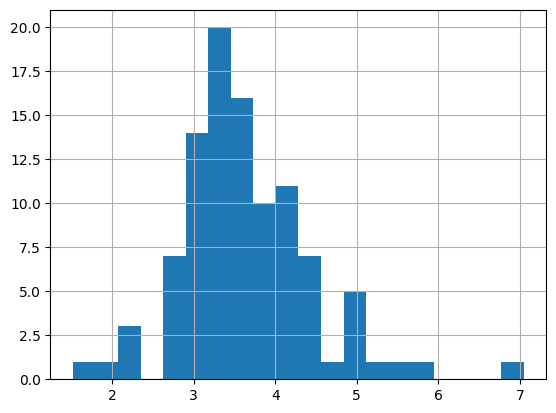

In [210]:
# 5. Do these songs gravitate around an "optimal duration"?
df_songs_final['duration'].hist(bins=20)

In terms of incidence in this list, the optimal duration of the song is between 3 and 4 minutes. Note that the fall is a bit more abruptly if you shorten the song below 3 minutes rather than if you stretch it a bit more over 4 minutes.

In [189]:
fig = px.scatter(df_songs_final, x='duration', y='Streams (Billions)')
fig.show()

In [194]:
df_songs_final.sort_values(by='Streams (Billions)', ascending=False).head()

,Song,Streams (Billions),Aging in Days,Estimated Earnings (Million USD),key,mode,duration,tempo
0,Blinding Lights,3.449,1195.0,13.8,1,1,3.33,171.0
1,Shape of You,3.398,2252.0,13.59,1,0,3.90,96.0
2,Dance Monkey,2.770,1398.0,11.08,6,0,3.49,98.0
3,Someone You Loved,2.680,1581.0,10.72,1,1,3.04,110.0
4,Rockstar,2.620,2000.0,10.48,5,0,3.64,160.0


Either by the scatter plot and by the dataset sorted by #streams, one might infer that there's a similar tendency to the interval between 3 and 4 minutes. However, note that in the scatter plot, the 3 to 4 minute interval also represents the "bottom" of the stream counts.

In [193]:
corr_mat = df_songs_final[['duration', 'Streams (Billions)']].corr()
corr_mat

,duration,Streams (Billions)
duration,1.000000,-0.080838
Streams (Billions),-0.080838,1.000000


The correlation between these two metrics is small (~ negative 8%), for the samples we have. It does not discard a cause-effect relationship between them, but more factors need to be considered to make a conclusion (such as specificity, consistency, mechanism, etc.). 

In [191]:
# 6. Is there a correlation between "streams" and "tempo"?
corr_mat = df_songs_final[['tempo', 'Streams (Billions)']].corr()
corr_mat    

,tempo,Streams (Billions)
tempo,1.000000,-0.097438
Streams (Billions),-0.097438,1.000000


Apparently, there's a small correlation between tempo (bpm) and the number of streams.

<AxesSubplot:>

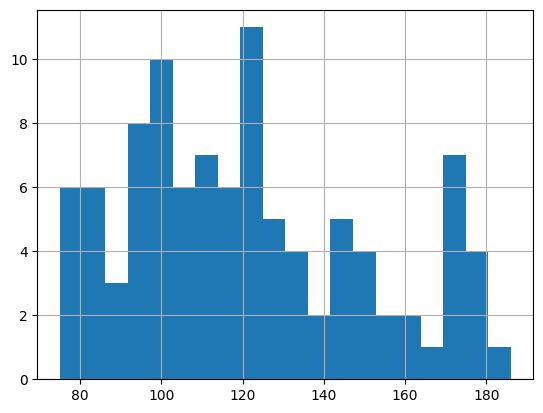

In [211]:
df_songs_final['tempo'].hist(bins=20)

In [199]:
[df_songs_final['tempo'].min(), df_songs_final['tempo'].max(), df_songs_final['tempo'].mean(), np.round(df_songs_final['tempo'].std(), 2)]

[75.0, 186.0, 121.26, 29.52]

The songs tempos range from 75 to 186 bpm, having an average of 121 bpm and a standard deviation of 30 bpm. You can check what both extremes look like by clicking [here](https://www.google.com/search?q=online+metronome&rlz=1C5CHFA_enBR996BR996&sxsrf=AJOqlzW4ZSBHTZyxq5agA_tcAmdoj-FTtA%3A1678648330096&ei=CiQOZI2_BbydwbkPt5WigA0&ved=0ahUKEwiN7KurjNf9AhW8TjABHbeKCNAQ4dUDCA8&uact=5&oq=online+metronome&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIFCAAQkQIyBQgAEJECMgUIABCRAjIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQ6BAgjECc6BQguEIAEOggILhDUAhCABEoECEEYAFAAWK4LYJAMaABwAXgAgAH4AYgB7hiSAQQyLTE0mAEAoAEBwAEB&sclient=gws-wiz-serp)

In [217]:
# 8. What are the artists with more streams per day?
df_uniq_art.sort_values(by='Streams per day (Millions)', ascending=False).head()

,Artist,Songs,Streams (Billions),Streams per day (Millions),Oldest song,Oldest song aging,Estimated Earnings (Millions USD)
46,Lil Nas X,2,3.33,4.68,Montero (Call Me by Your Name),712.0,13.33
63,Post Malone,5,10.6,4.58,Congratulations,2315.0,42.41
60,Olivia Rodrigo,2,3.5,4.44,Drivers License,789.0,14.01
39,Justin Bieber,6,11.19,4.15,Sorry,2694.0,44.72
28,Harry Styles,2,4.15,4.04,Watermelon Sugar,1027.0,16.6


In [220]:
# 9. What artist have the oldest song in the list, and which song is it?
df_uniq_art.sort_values(by='Oldest song aging', ascending=False).head(1)

,Artist,Songs,Streams (Billions),Streams per day (Millions),Oldest song,Oldest song aging,Estimated Earnings (Millions USD)
65,Queen,2,3.59,0.21,Bohemian Rhapsody,17295.0,14.53


PS: The aging is regarded as of the launching of the song itself, not in the platform

In [225]:
# 10. How much revenue all 100 songs have made together?
total_revenue = df_merge['Streams (Billions)'].sum() * (10**3) * 4000
np.round(total_revenue, 0)/(10**6)

758.4

Assuming each 1 million stream a song maked 4000 USD, all these 100 songs combined have generated a total revenue of 758.4 million USD